In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import statsmodels.api as sm
import datetime
from plotly import tools
from plotly.graph_objs import Bar, Figure, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#データの取得
original_data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/covid-19_pred/130001_tokyo_covid19_patients.csv",index_col='公表_年月日', parse_dates=True)
original_data.head()

,No,全国地方公共団体コード,都道府県名,市区町村名,発症_年月日,確定_年月日,患者_居住地,患者_年代,患者_性別,患者_職業,患者_状態,患者_症状,患者_渡航歴の有無フラグ,患者_接触歴の有無フラグ,備考,退院済フラグ
公表_年月日,,,,,,,,,,,,,,,,
2020-01-24,1,130001,東京都,NaN,NaN,NaN,湖北省武漢市,40代,男性,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-25,2,130001,東京都,NaN,NaN,NaN,湖北省武漢市,30代,女性,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-30,3,130001,東京都,NaN,NaN,NaN,湖南省長沙市,30代,女性,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-02-13,4,130001,東京都,NaN,NaN,NaN,都内,70代,男性,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-02-14,5,130001,東京都,NaN,NaN,NaN,都内,50代,女性,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [4]:
positive_data = original_data.groupby("公表_年月日").count()["全国地方公共団体コード"].reset_index()
positive_data = positive_data.rename(columns={"全国地方公共団体コード":"感染者数"})
positive_data

,公表_年月日,感染者数
0,2020-01-24,1
1,2020-01-25,1
2,2020-01-30,1
3,2020-02-13,1
4,2020-02-14,2
...,...,...
595,2021-10-06,149
596,2021-10-07,143
597,2021-10-08,138
598,2021-10-09,82


In [5]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 4.6 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=792ced3df0782125104d267a0e725c02072984b8b9cc034a6b989382e7fb10c1
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


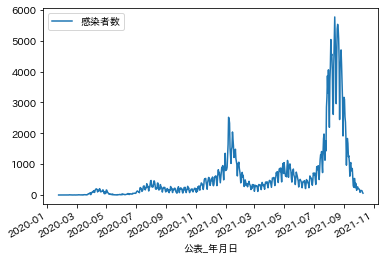

In [6]:
#感染者の推移のプロット
import matplotlib.pyplot as plt
import japanize_matplotlib
positive_data.plot(x=positive_data.columns[0])

In [7]:
positive_data.set_index('公表_年月日', inplace = True)

In [8]:
#csvファイル生成&ダウンロード
''' from google.colab import files
filename =  "positive_num.csv"
positive_data.to_csv(filename, encoding = 'utf-8-sig') 
files.download(filename) '''

' from google.colab import files\nfilename =  "positive_num.csv"\npositive_data.to_csv(filename, encoding = \'utf-8-sig\') \nfiles.download(filename) '

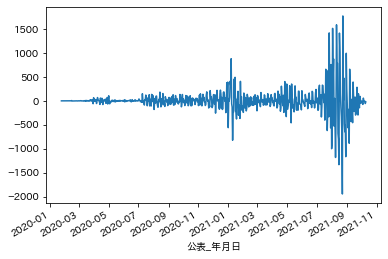

In [9]:
#残差の出力
positive_data["感染者数"] = positive_data["感染者数"].astype('float64')
ts=positive_data["感染者数"]
diff = ts.diff()
diff = diff.dropna()
diff.plot()

In [10]:
import warnings
warnings.filterwarnings('ignore') # 計算警告を非表示

# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
res_selection

{'aic':              0            1            2
 0          NaN  8427.003498  8409.185295
 1  8427.020786  8402.321346  8387.795878
 2  8424.379954  8370.653986  8236.001496
 3  8356.128511  8312.523313  8201.913445
 4  8318.826804  8301.007988  8199.725735, 'aic_min_order': (4, 2)}

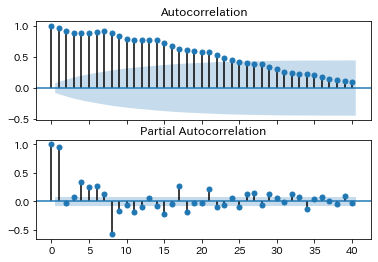

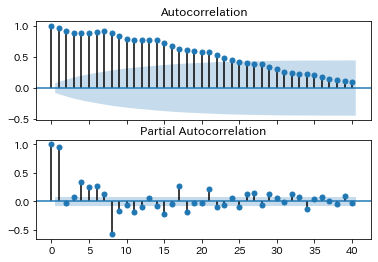

In [11]:
#コレログラム
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1) #自己相関
sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2) #偏相関

In [12]:
res = sm.tsa.seasonal_decompose(ts, freq=7) #freqに任意の数値を入力し、季節性を設定
fig = tools.make_subplots(rows=4, cols=1)
fig.append_trace(Scatter(x=res.observed.index, y=res.observed, name='Original'), 1, 1)
fig.append_trace(Scatter(x=res.trend.index, y=res.trend, name='Trend'), 2, 1)
fig.append_trace(Scatter(x=res.seasonal.index, y=res.seasonal, name='Seasonal'), 3, 1)
fig.append_trace(Scatter(x=res.resid.index, y=res.resid, name='Resid'), 4, 1)
fig['layout'].update(title='成分分解')
iplot(fig)

In [13]:
#定常性の有無の検討
res = sm.tsa.stattools.adfuller(ts)
print('p-value = {:.4}'.format(res[1]))

#p-value = 0.0023より、帰無仮説を棄却する

p-value = 0.0023


In [14]:
data = [Scatter(x=positive_data.index, y=ts.diff())]
fig = Figure(data=data, layout=Layout(title='差分データ'))
iplot(fig)

In [15]:
train = positive_data[positive_data.index < '2021-06-01']
test = positive_data[positive_data.index >= '2021-06-01']

In [16]:
def fit_model(ts_train, order, seasonal_order):
    model = SARIMAX(
        ts_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False)
    result = model.fit()
    return result

def eval_model(ts_train, ts_test, result):
    train_pred = result.predict()
    test_pred = result.forecast(len(ts_test))
    test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

    train_rmse = np.sqrt(mean_squared_error(ts_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(ts_test, test_pred))
    print('RMSE(train):\t{:.5}\nRMSE(test):\t{:.5}'.format(
        train_rmse, test_rmse))
    return train_pred, test_pred, test_pred_ci

def make_fig(ts, train_pred, test_pred, test_pred_ci, result, title='SARIMA'):
  data = [
      Scatter(x=ts.index, y=ts, name='Original', line=dict(dash='dot')),
      Scatter(x=train_pred.index, y=train_pred, name='Predict(train)'),
      Scatter(x=test_pred.index, y=test_pred, name='Predict(test)'),
      # Scatter(x=result.resid.index, y=result.resid, name='Resid')
  ]
  fig1 = Figure(data=data, layout=Layout(title=title))

  fig2, ax = plt.subplots()
  ts.plot(ax=ax, label='Original', linestyle="dashed")
  train_pred.plot(ax=ax, label='Predict(train)')
  test_pred.plot(ax=ax, label='Predict(test)')
  ax.fill_between(
      test_pred_ci.index,
      test_pred_ci.iloc[:, 0],
      test_pred_ci.iloc[:, 1],
      color='k',
      alpha=.2)
  ax.legend()
  ax.set_title(title)

  fig3, ax = plt.subplots()
  ts['2018-04-01':].plot(ax=ax, label='Original', linestyle="dashed")
  test_pred.plot(ax=ax, label='Predict(test)', color='g')
  ax.fill_between(
      test_pred_ci.index,
      test_pred_ci.iloc[:, 0],
      test_pred_ci.iloc[:, 1],
      color='k',
      alpha=.2)
  ax.legend()
  ax.set_title(title)

  return fig1, fig2, fig3

In [17]:
order=(4,1,2)
seasonal_order=(1,1,1,90)
result = fit_model(train, order, seasonal_order)
train_pred, test_pred, test_pred_ci = eval_model(train, test, result)
result.summary()

RMSE(train):	118.13
RMSE(test):	1989.6


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               感染者数   No. Observations:                  468
Model:             SARIMAX(4, 1, 2)x(1, 1, 1, 90)   Log Likelihood               -1815.789
Date:                            Sun, 14 Nov 2021   AIC                           3649.578
Time:                                    10:10:15   BIC                           3682.387
Sample:                                         0   HQIC                          3662.734
                                            - 468                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5368      0.108     -4.982      0.000      -0.748      -0.326
ar.L2          0.3926      0.087      4.513      0.000       0.222       0.563
ar.L3         -0.4043      0.056     -7.246      0.000      -0.514      -0.295
ar.L4         -0.3838      0.057     -6.741      0.000      -0.495      -0.272
ma.L1          0.4302      0.109      3.939      0.000       0.216       0.644
ma.L2         -0.5328      0.097     -5.478      0.000      -0.723      -0.342
ar.S.L90      -0.6045      0.183     -3.310      0.001      -0.962      -0.247
ma.S.L90      -0.3337      0.211     -1.584      0.113      -0.747       0.079
sigma2      2.141e+04   1356.910     15.779      0.000    1.88e+04    2.41e+04
===================================================================================
Ljung-Box (Q):                      323.00   Jarque-Bera (JB):               600.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.87   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
''' title = 'SARIMA order={}, seasonal_order={}'.format(order, seasonal_order)
fig1, fig2, fig3 = make_fig(ts, train_pred, test_pred, test_pred_ci, result, title)
iplot(fig1, image=save_image, filename='SARIMA1-1')
if save_image:
    fig2.savefig('SARIMA1-2')
    fig3.savefig('SARIMA1-3') '''

" title = 'SARIMA order={}, seasonal_order={}'.format(order, seasonal_order)\nfig1, fig2, fig3 = make_fig(ts, train_pred, test_pred, test_pred_ci, result, title)\niplot(fig1, image=save_image, filename='SARIMA1-1')\nif save_image:\n    fig2.savefig('SARIMA1-2')\n    fig3.savefig('SARIMA1-3') "

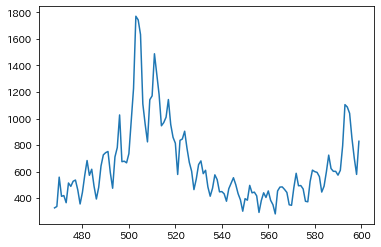

In [19]:
plt.plot(test_pred, label="model-pred")

In [20]:
first_day = datetime.date(2021, 6,1)
i = 0
dt_col = []
while i < len(test_pred):
  dt = first_day + datetime.timedelta(days=i)
  dt_col.append(dt)
  i += 1
dt_col = pd.Series(dt_col)



In [21]:
test_pred.reset_index(drop=True, inplace=True)
test_pred = pd.concat([dt_col,test_pred],axis=1)
test_pred

,0,1
0,2021-06-01,326.336514
1,2021-06-02,336.866520
2,2021-06-03,557.973753
3,2021-06-04,413.537963
4,2021-06-05,419.064739
...,...,...
127,2021-10-06,1039.227793
128,2021-10-07,851.497782
129,2021-10-08,701.918835
130,2021-10-09,578.658805


In [22]:
test_pred = test_pred.rename(columns={0:'公表_年月日',1:"感染者数"})
test_pred = test_pred.set_index('公表_年月日')
test_pred

,感染者数
公表_年月日,
2021-06-01,326.336514
2021-06-02,336.866520
2021-06-03,557.973753
2021-06-04,413.537963
2021-06-05,419.064739
...,...
2021-10-06,1039.227793
2021-10-07,851.497782
2021-10-08,701.918835


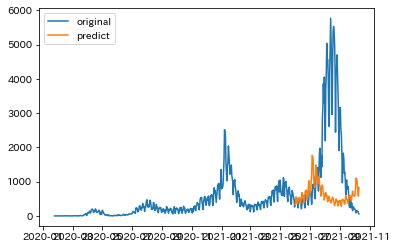

In [23]:
plt.plot(positive_data,label="original")
plt.plot(test_pred,label="predict")
plt.legend()
plt.show()